Main database Link : 
https://archive.ics.uci.edu/ml/datasets/AI4I+2020+Predictive+Maintenance+Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/MALIS/project/data/ai4i2020.csv')

In [ ]:
df.dtypes

UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object

In [ ]:
df.head

<bound method NDFrame.head of         UDI Product ID Type  Air temperature [K]  ...  HDF  PWF  OSF  RNF
0         1     M14860    M                298.1  ...    0    0    0    0
1         2     L47181    L                298.2  ...    0    0    0    0
2         3     L47182    L                298.1  ...    0    0    0    0
3         4     L47183    L                298.2  ...    0    0    0    0
4         5     L47184    L                298.2  ...    0    0    0    0
...     ...        ...  ...                  ...  ...  ...  ...  ...  ...
9995   9996     M24855    M                298.8  ...    0    0    0    0
9996   9997     H39410    H                298.9  ...    0    0    0    0
9997   9998     M24857    M                299.0  ...    0    0    0    0
9998   9999     H39412    H                299.0  ...    0    0    0    0
9999  10000     M24859    M                299.0  ...    0    0    0    0

[10000 rows x 14 columns]>

In [ ]:
df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000




```
# Ce texte est au format code
```

Let's first try to understand the data, and have a first look at the Tool Wear parameter. The tool wear is the number of consecutive minutes one tool has been used. When it goes down to 0 it means that the tool broke.

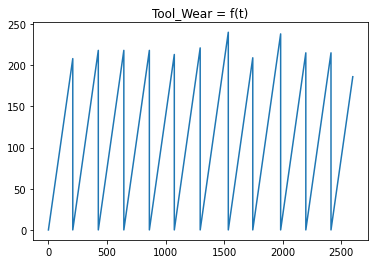

In [ ]:
totalTime = [0]*10000
for i in range(1,10000):
  if df['Tool wear [min]'][i] == 0:
    totalTime[i] = totalTime[i-1]+df['Tool wear [min]'][i]
  else:
    totalTime[i] = totalTime[i-1] + df['Tool wear [min]'][i]-df['Tool wear [min]'][i-1]
#plt.plot(totalTime)
df['totalTime'] = totalTime

plt.figure()
plt.title("Tool_Wear = f(t)")
plt.plot([df['totalTime'][i] for i in range(1000)], df['Tool wear [min]'][:1000])

And if we take the problem in the other way around, we can compute and draw the number of days before the tool breaks:

[78, 1088, 1510, 1683, 1764, 1997, 2167, 2245, 2672, 2865, 2942, 3530, 3612, 3696, 3866, 4035, 4208, 4386, 4470, 4647, 4817, 5142, 5310, 5402, 5910, 6000, 6173, 6257, 6341, 6420, 6760, 7088, 7427, 7511, 7688, 7850, 8112, 8200, 8358, 8610, 8691, 8847, 9019, 9175, 9577, 9759]
78
1088
1510
1683
1764
1997
2167
2245
2672
2865
2942


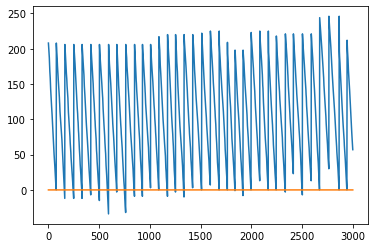

In [ ]:
y = []

UDI_breaks = []
for i in df.UDI:
  if df.TWF[i-1] == 1:
    UDI_breaks.append(i);
print(UDI_breaks)
UDI_breaks_iterator = iter(UDI_breaks)
actual_break_UDI = next(UDI_breaks_iterator)

for i in range(3000):
  if i > actual_break_UDI:
    print(actual_break_UDI)
    actual_break_UDI = next(UDI_breaks_iterator)
  y.append(df['Tool wear [min]'][actual_break_UDI-1] - df['Tool wear [min]'][i])
  
plt.plot(y)
plt.plot([0]*3000)

Let's have a closer look at our distribution of failure point. Let's compute the mean interval between two tool failures and the variance of it:

Tool wear failure interval distribution
Mean:               216.3695652173913 min
Variance:           146.97211720226844 min
Standard Deviation:  12.123205731252293 min


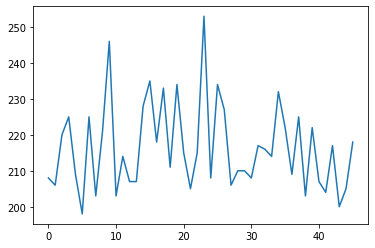

In [ ]:
intervals_length = []
for i in df.UDI:
  if df.TWF[i-1] == 1:
    intervals_length.append(df['Tool wear [min]'][i-1])

plt.plot([i for i in range(len(intervals_length))], intervals_length)

intervals_length = np.array(intervals_length)
print("Tool wear failure interval distribution")
print("Mean:               {} min".format(np.mean(intervals_length)))
print("Variance:           {} min".format(np.var(intervals_length)))
print("Standard Deviation:  {} min".format(np.std(intervals_length)))


Let's create a dataset with cumulative data (First with the Torque and the Rpm only)

In [ ]:
data = {
    'Torque':[0]*9999,
    'Rpm':[0]*9999,
    'ToolWear':[0]*9999,
    'Failure':[0]*9999
}
cumulative_df = pd.DataFrame(data)
lastChangePoint = 0
for i in range(9999):
  cumulative_df['ToolWear'][i] = df['Tool wear [min]'][i]
  if df['Tool wear [min]'][i] == 0:
    cumulative_df['Torque'][i] = df['Torque [Nm]'][i] * (df['totalTime'][i+1]-df['totalTime'][i])
    cumulative_df['Rpm'][i] = df['Rotational speed [rpm]'][i] * (df['totalTime'][i+1]-df['totalTime'][i])
  else:
    cumulative_df['Torque'][i] = df['Torque [Nm]'][i] * (df['totalTime'][i+1]-df['totalTime'][i]) + cumulative_df['Torque'][i-1]
    cumulative_df['Rpm'][i] = df['Rotational speed [rpm]'][i] * (df['totalTime'][i+1]-df['totalTime'][i]) + cumulative_df['Rpm'][i-1]
  if df['TWF'][i]==1:
    cumulative_df['Failure'][i]=1
  else:
    cumulative_df['Failure'][i]=0

  

In [ ]:
cumulative_df.head(80)

Let's split in a training and test dataset:

In [ ]:
X_train, X_test, y_train, y_test=train_test_split(cumulative_df.drop(['Failure'], axis=1), cumulative_df[['Failure']], test_size=4000)
print(np.ravel(np.array(y_train)))

[0 0 0 ... 0 0 0]


Let's first try a Logistic regression on the cumulative torque and rpm to predict if there is a tool failure or not.

In [ ]:
LR_model_1 = LogisticRegression(solver='liblinear', max_iter=2000)
LR_model_1.fit(X_train, np.ravel(np.array(y_train)));

In [ ]:
X_train, X_test, y_train, y_test=train_test_split(cumulative_df.drop(['Failure'], axis=1), cumulative_df[['Failure']], test_size=4000)

LR_model_1.fit(X_train, np.ravel(np.array(y_train)));

def predict_and_test(LR_model,X,y):
  y_hat = LR_model.predict(X)
  y = np.array(y)
  corrects = 0
  corrects_0 = 0
  count_1 = 0
  count_0 = 0
  for i in range(len(y)):
    if (y[i] == 1):
      count_1 += 1
      if(y_hat[i] == y[i]):
        corrects+=1
    if (y[i]==0):
      count_0 += 1
      if (y_hat[i] == y[i]):
        corrects_0 += 1
  print(count_1)
  return (corrects/count_1,corrects_0/count_0)


accuracy_training = predict_and_test(LR_model_1,X_test,y_test)
print(accuracy_training)
print(np.sum(np.array(y_test))/len(y_test))

15
(0.0, 1.0)
0.00375


We are not getting any results for now because there is way too many 0 compared to 1 in y_test. We should try to diminish the ratio 0/1 by only keeping the one just before the failure.